La primera parte del pipeline consiste en crear un método para identificar las páginas con imagenes dentro de ellas, para esto hemos decidido transformar la imágen de color a escala de grises hacer un filtro para difuminar la imágen y usar la varianza de esta para ver si existe alguna imágen. La idea consiste en que aquellas paginas que tienen solo letras o están vacías tienden a ser más monotonas, pero aquellas páginas con imágenes son más heterogeneas.  

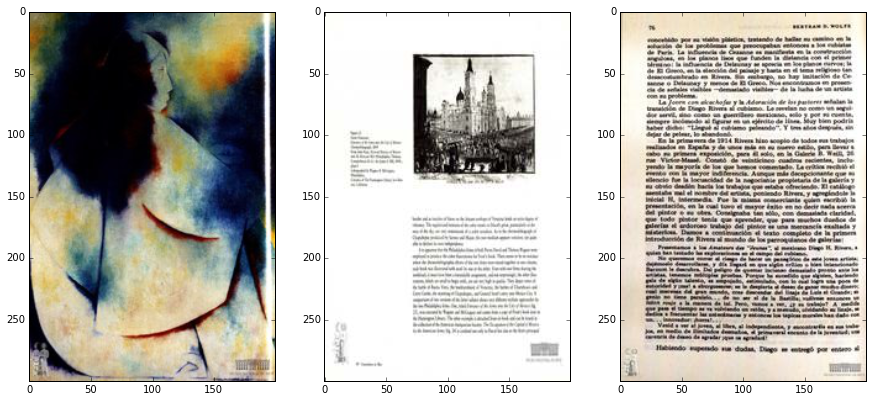

In [56]:
import os
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline 

pint_1 = io.imread('Salidas_pruebas/Imagenes/fcp-int_00000039.jpg')
pint_2 = io.imread('Salidas_pruebas/Imagenes/etw-int_00000045.jpg')
pint_3 = io.imread('Salidas_pruebas/Imagenes/aam-int_00000083.jpg')

fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(pint_1)
axs[1].imshow(pint_2)
axs[2].imshow(pint_3)

Convertimos las imágenes en escala de grises para poder sacar de manera rápida y directa la varianza.

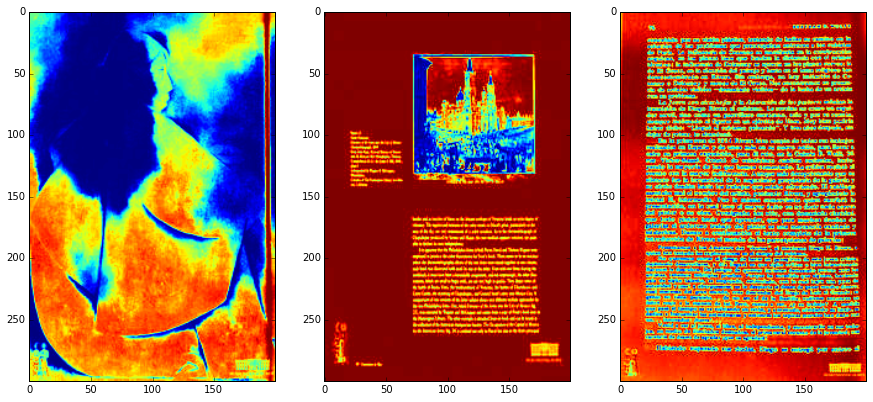

In [57]:
from skimage.color import rgb2gray
pint_1_gray = rgb2gray(pint_1)
pint_2_gray = rgb2gray(pint_2)
pint_3_gray = rgb2gray(pint_3)

fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(pint_1_gray)
axs[1].imshow(pint_2_gray)
axs[2].imshow(pint_3_gray)

Aplicamos un filtro porque como las imágenes con texto tienden a tener un una ambivalencia entre negro y blanco que pueden llegar a dar resultados de varianzas altas sin tener imágenes dentro de ellas. Como se puede ver en el ejemplo siguiente en donde se ve que la varianza de la tercera página es mayor que la de la segunda página

In [58]:
pint_1_gray.var(), pint_2_gray.var(), pint_3_gray.var() 

(0.10746674304512749, 0.051522482303793339, 0.057488501543436939)

Con la aplicación del filtro se puede notar que la varianza ahora de la tercera página es mucho menor a la segunda. Se podría jugar con el parámetro de sigma para encontrar cuál es el mejor, pero con diferentes pruebas hemos encontrado que con sigma = 2 es una buena forma de distinguir las páginas solo con texto de las que incluyen imágenes. Por otro lado, decidir el nivel de varianza que deben tener para ser consideradas imágenes, hemos probado con varios niveles y hemos decidido que sea 0.05 el nivel mínimo de varianza para seleccionar a las imágenes. 

0.0965119442321 0.0404791532566 0.0146621418445


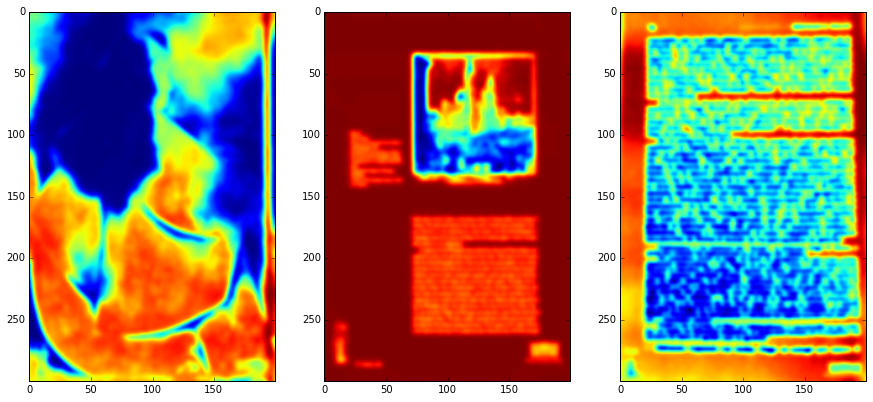

In [59]:
from skimage.filters import gaussian_filter

parametro = 2
pint_1_filtro = gaussian_filter(pint_1_gray,sigma=parametro)
pint_2_filtro = gaussian_filter(pint_2_gray,sigma=parametro)
pint_3_filtro = gaussian_filter(pint_3_gray,sigma=parametro)

print pint_1_filtro.var(), pint_2_filtro.var(), pint_3_filtro.var() 

fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(pint_1_filtro)
axs[1].imshow(pint_2_filtro)
axs[2].imshow(pint_3_filtro)

Después de identificar para cada libro las páginas que tienen imágenes, copiamos dichos jpgs a una carpeta nueva y reducimos el tamaño del jpg a una estructura de 200x300. Esto porque al momento de volver la imágen en vector, cada imágen puede tener un diferente número de pixeles oscilando entro los 2000 y los 2500 de ancho y entre 3000 y 3500 de alto, lo que imposibilitaría poder formar una matriz con todas las imágenes. Aunado a lo anterior, una matriz con un ancho de 2500x3500, es decir una matriz con cerca de 8,750,000 columnas, sería intratable. Con la transformación, nos quedaría una matriz con 6,000 columnas y filas como pinturas se encontraran en los libros.

El siguiente proceso consiste en hacer un nuevo filtro de las páginas, queremos hacer análisis sobre un tipo de páginas en especial, en las páginas que casi en toda su extensión hay pintura, no nos interesa hacer análisis en páginas que tienen imágenes pequeñas, porque podemos encontrar páginas en las que hay 3 pinturas y el análisis posterior no sería sobre una pintura sino sobre una combinación de las 3.

Dado lo anterior, realizaremos un clustering, que nos sirva para formar grupos de paginas de acuerdo a la estructura, para esto crearemos la matriz con cada imagen en blanco y negro, en donde cada fila es una página con varianza alta y cada columna el deshilado de la matriz de la imágen en escala de grises, luego utilizaremos la descomposición de valores singulares para reducir la dimensionalidad y finalmente haremos clustering con Kmeans. El número de Kmeans lo queremos pequeño pero suficientemente grande para separar bien las páginas, decidimos con 5 porque nos ha servido, pero se pueden intentar diferentes números.

Como ejemplo, los archivos del primer cluster se verían así: 

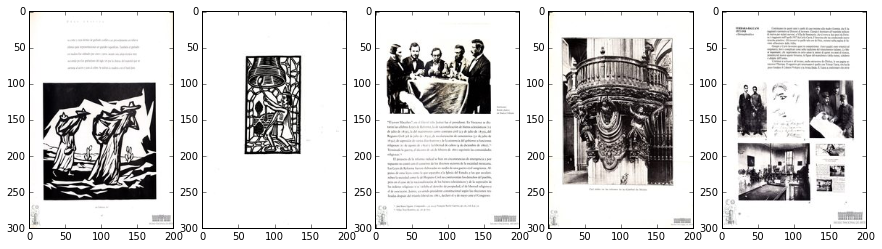

In [66]:
pint_1 = io.imread('/home/jared/cluster_1/aam-int_00000112.jpg')
pint_2 = io.imread('/home/jared/cluster_1/aam-int_00000113.jpg')
pint_3 = io.imread('/home/jared/cluster_1/aam-int_00000118.jpg')
pint_4 = io.imread('/home/jared/cluster_1/aam-int_00000120.jpg')
pint_5 = io.imread('/home/jared/cluster_1/aam-int_00000121.jpg')

fig, axs = plt.subplots(1,5,figsize=(15,15))
axs[0].imshow(pint_1)
axs[1].imshow(pint_2)
axs[2].imshow(pint_3)
axs[3].imshow(pint_4)
axs[4].imshow(pint_5)

Los del tercer cluster:

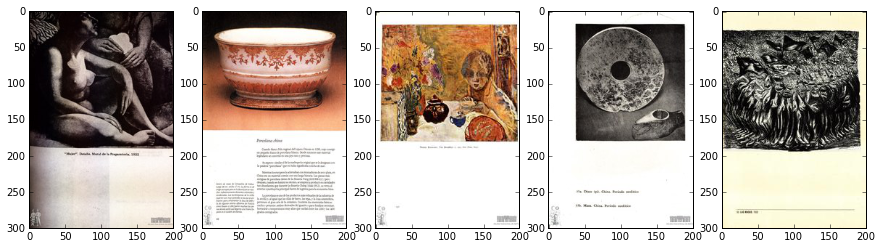

In [65]:
pint_1 = io.imread('/home/jared/cluster_3/aam-int_00000077.jpg')
pint_2 = io.imread('/home/jared/cluster_3/aam-int_00000078.jpg')
pint_3 = io.imread('/home/jared/cluster_3/aam-int_00000085.jpg')
pint_4 = io.imread('/home/jared/cluster_3/aam-int_00000087.jpg')
pint_5 = io.imread('/home/jared/cluster_3/aam-int_00000111.jpg')

fig, axs = plt.subplots(1,5,figsize=(15,15))
axs[0].imshow(pint_1)
axs[1].imshow(pint_2)
axs[2].imshow(pint_3)
axs[3].imshow(pint_4)
axs[4].imshow(pint_5)

Y los del cuarto cluster:

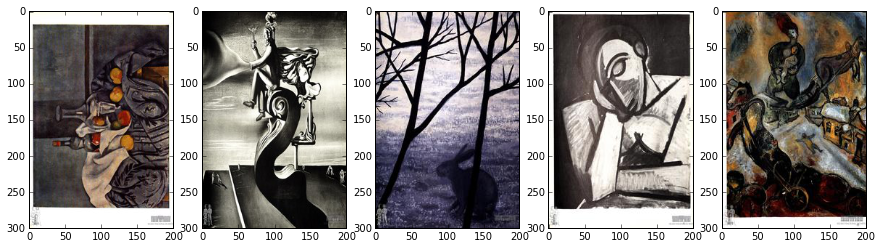

In [64]:
pint_1 = io.imread('/home/jared/cluster_4/ana-int_00000187.jpg')
pint_2 = io.imread('/home/jared/cluster_4/ana-int_00000190.jpg')
pint_3 = io.imread('/home/jared/cluster_4/ana-int_00000200.jpg')
pint_4 = io.imread('/home/jared/cluster_4/ana-int_00000211.jpg')
pint_5 = io.imread('/home/jared/cluster_4/ana-int_00000216.jpg')

fig, axs = plt.subplots(1,5,figsize=(15,15))
axs[0].imshow(pint_1)
axs[1].imshow(pint_2)
axs[2].imshow(pint_3)
axs[3].imshow(pint_4)
axs[4].imshow(pint_5)